In [1]:
import oracledb
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import math 
import csv
from datetime import datetime
#userpwd = getpass.getpass("Enter password: ")

/home/gagarwal/.local/lib/python3.6/site-packages/oracledb/__init__.py:39: UserWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in python-oracledb and will be removed in a future release
  warnings.warn(message)
/home/gagarwal/.local/lib/python3.6/site-packages/oracledb/connection.py:45: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from . import base_impl, thick_impl, thin_impl


In [2]:
#here define scaling function for leakage current
#arguments to be given in Celsius

def scale_current(t1, t2):
    T1_absolute = t1+273.15
    T2_absolute = t2+273.15
    return (pow(T1_absolute,2)/pow(T2_absolute,2))*math.exp((-1.12/(2*8.625*pow(10,-5)))*((1/T1_absolute)  - (1/T2_absolute)))

temperature_factor = scale_current(-20, 25)
print(temperature_factor)

0.015021417861585536


In [3]:
doPlots = True

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font 

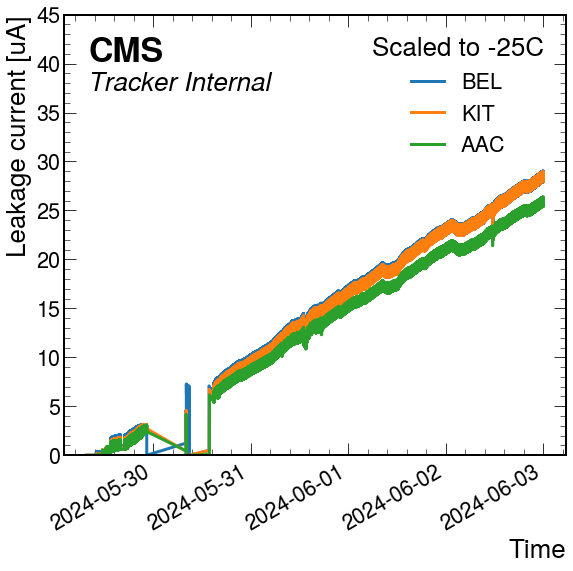

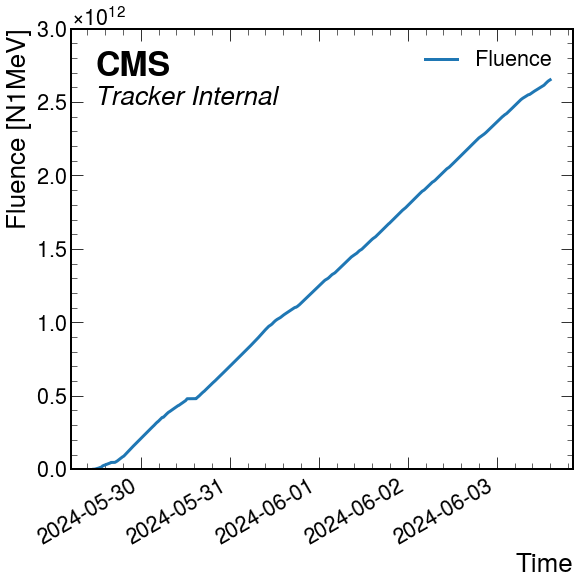

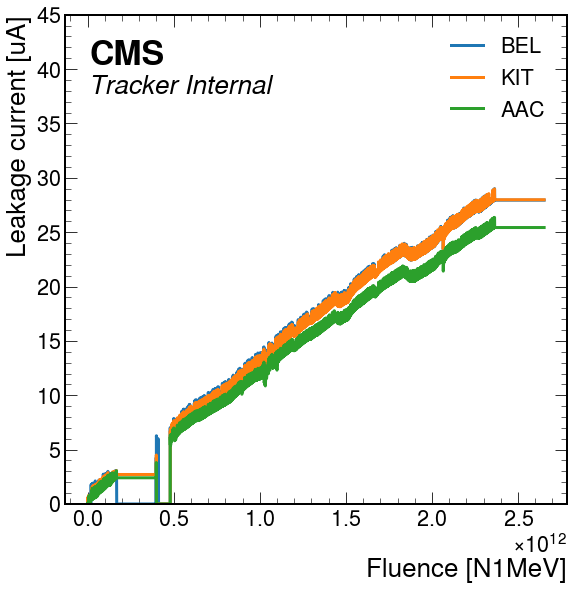

In [4]:
connection = oracledb.connect( user="CHARMDB", password='CHarM2024TB)', dsn="CMSR", config_dir='.local/lib/python3.6/site-packages/oracledb')

cursor = connection.cursor()
data = {}
modules_IDs = {
    'BEL': 4,
    'KIT': 8,
    'AAC': 10
}

## First, get the leakage current from the database

for iModule in modules_IDs.keys():
    # time[iModule] = []
    # leakage_current[iModule] = []
    data[iModule] = {"Time":[], "{}_Ileak".format(iModule):[]}

    query = "select fwcaenchannel.actual_imon, fwcaenchannel.change_date from fwcaenchannel JOIN dp_name2id on fwcaenchannel.dpid=dp_name2id.id WHERE DPID=" \
            + str(modules_IDs[iModule]) + " and fwcaenchannel.change_date >'29-May-2024' and fwcaenchannel.change_date <'3-June-2024' ORDER BY fwcaenchannel.change_date ASC "
    
    for row in cursor.execute(query):
        if (row[0] is not None):
            data[iModule]["{}_Ileak".format(iModule)].append(temperature_factor*float(row[0]))
            data[iModule]["Time"].append(row[1])
            
_df = pd.merge_asof(pd.DataFrame(data['BEL']), pd.DataFrame(data['KIT']), on="Time", direction="nearest")
df_Ileak = pd.merge_asof(_df, pd.DataFrame(data['AAC']), on="Time", direction="nearest")
del _df

df_Ileak['Time'] = pd.to_datetime(df_Ileak['Time'])
df_Ileak.set_index('Time', inplace=True)

## Plot leakage current vs. Time
if doPlots:
    fig, ax  = plt.subplots(figsize=(9,9))
    plt.xticks(rotation=45)
    hep.cms.text(ax=ax,loc=2, text = "Tracker Internal")
    df_Ileak.plot(ax=ax, linewidth = 3)
    label = [item.split('_')[0] for item in list(df_Ileak.keys())]
    ax.legend(label, loc='upper right', title = "Scaled to -25C")
    ax.set_xlabel("Time")
    ax.set_ylabel("Leakage current [uA]")
    ax.set_ylim(0, 45)
    fig.savefig("Ileak.pdf", bbox_inches='tight')

## Second, get the fluence from the database

data_f = {"Time":[], "Fluence":[]}
with open('data/data_CHARM_V2.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_time = datetime.strptime(row['Time'], "%m/%d/%Y %H:%M:%S")
        data_f["Time"].append(converted_time) 
        data_f["Fluence"].append(float(row['N1MeV_RAW0']))
        
df_fluence = pd.DataFrame(data_f)
df_fluence['Time'] = pd.to_datetime(df_fluence['Time'])
df_fluence.set_index('Time', inplace=True)

## Plot fluence vs. Time
if doPlots:
    fig, ax  = plt.subplots(figsize=(9,9))
    plt.xticks(rotation=45)
    hep.cms.text(ax=ax,loc=2, text = "Tracker Internal")
    df_fluence.plot(ax=ax, linewidth = 3)
    label = [item.split('_')[0] for item in list(df_fluence.keys())]
    ax.legend(label, loc='upper right')
    ax.set_xlabel("Time")
    ax.set_ylabel("Fluence [N1MeV]")
    ax.set_ylim(0, 3e12)
    ax.ticklabel_format(axis = 'y', useMathText=True)
    fig.savefig("Fluence.pdf", bbox_inches='tight')

## Merging Leakage current and fluence dataframes
df = pd.merge_asof(df_fluence, df_Ileak, left_index = True, right_index = True)
df_new = df
df_new.set_index('Fluence', inplace=True)

## Plot leakage current vs. fluence
if doPlots:
    fig, ax  = plt.subplots(figsize=(9,9))
    plt.xticks(rotation=45)
    hep.cms.text(ax=ax,loc=2, text = "Tracker Internal")
    df_new.plot(ax=ax, linewidth = 3)
    label = [item.split('_')[0] for item in list(df_new.keys())]
    ax.legend(label, loc='upper right')
    ax.xaxis.set_label_coords(0.1, -0.11)
    ax.set_xlabel("Fluence [N1MeV]")
    ax.set_ylabel("Leakage current [uA]")
    ax.ticklabel_format(useMathText=True)
    ax.set_ylim(0, 45)
    fig.savefig("Ileak_fluence.pdf", bbox_inches='tight')